# Implementing a CNN in TensorFlow and Keras for CIFAR-10 Classification
In this notebook, we’ll implement a Convolutional Neural Network (CNN) from scratch using Keras. We will use the CIFAR-10 Dataset and show a CNN architecture similar to the structure of VGG-16 but with fewer layers.

<img src='https://learnopencv.com/wp-content/uploads/2023/01/tensorflow-keras-cnn-cifar10-architecture.png' width=950 align='center'>

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from dataclasses import dataclass

In [3]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

##1. Load CIFAR-10 Dataset
The CIFAR-10 dataset consists of 60,000 color images from 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The CIFAR-10 dataset can be loaded from TensorFlow using the `load_data()` function.

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

170498071/170498071 [==============================] - 3s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


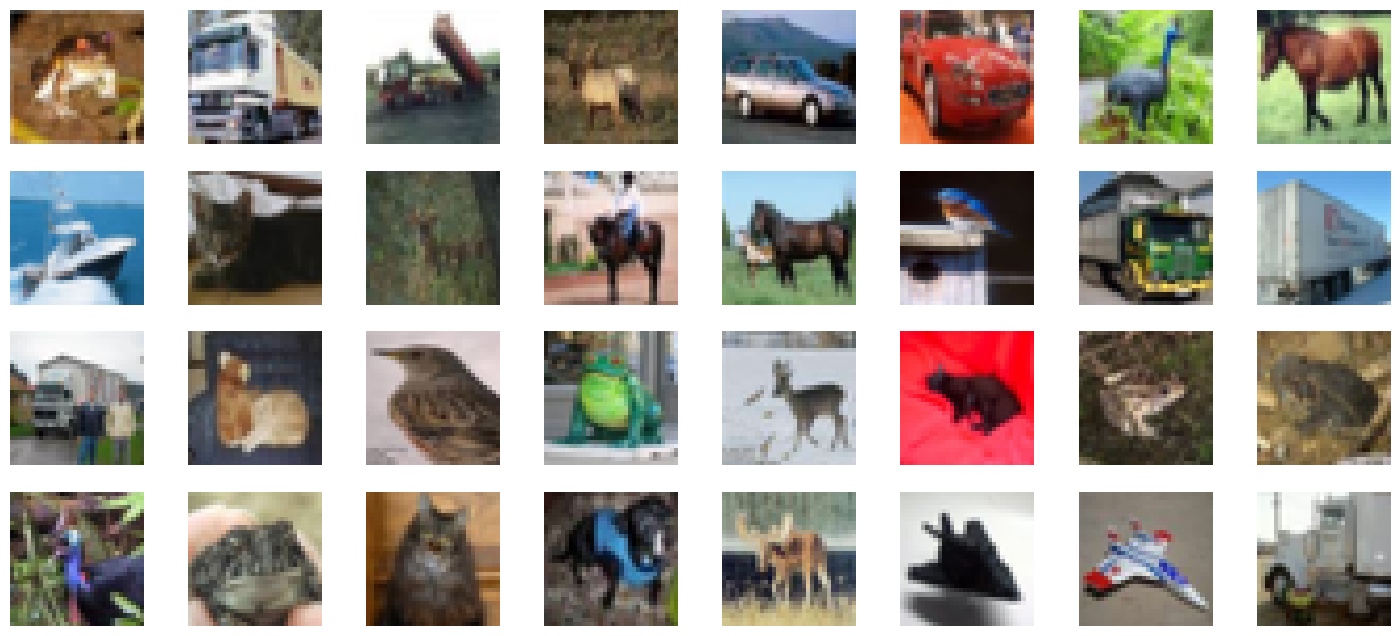

In [5]:
#inspect sample images in dataset. cifar10 images are quite small of 32x32 pixels
plt.figure(figsize=(18, 8))

num_rows = 4
num_cols = 8

for i in range(num_rows * num_cols):
    ax = plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_train[i, :, :])
    plt.axis("off")

## Data Preprocessing

In [6]:
# Normalize images to the range [0, 1].
X_train = X_train.astype("float32") / 255
X_test  = X_test.astype("float32")  / 255

# Change the labels from integer to categorical data.
print('Original (integer) label for the first training sample: ', y_train[2])

# Convert labels to one-hot encoding.
y_train = to_categorical(y_train)
y_test  = to_categorical(y_test)

print('After conversion to categorical one-hot encoded labels: ', y_train[2])

Original (integer) label for the first training sample:  [9]
After conversion to categorical one-hot encoded labels:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [7]:
# Using python dataclasses to have a single organised place
# for training configuration parameters
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES:  int = 10
    IMG_HEIGHT:   int = 32
    IMG_WIDTH:    int = 32
    NUM_CHANNELS: int = 3

@dataclass(frozen=True)
class TrainingConfig:
    EPOCHS:        int = 31
    BATCH_SIZE:    int = 256
    LEARNING_RATE: float = 0.001

## CNN Model Implementation
1. Build/Define a network model using `sequential()` and `.add()` methods
2. Compile the model with `model.compile()`
3. Train the model with `model.fit()`
4. Evaluate model performance.

Our model has a similar structure to VGG-16 but has fewer layers and a much smaller input image size, and therefore far fewer trainable parameters. The model contains three convolutional blocks followed by a fully connected layer and an output layer. For reference, we’ve included the number of channels at key points in the architecture. We have also indicated the spatial size of the activation maps at the end of each convolutional block. This is a good visual to refer back to when studying the code below.

<img src='https://learnopencv.com/wp-content/uploads/2023/01/tensorflow-keras-cnn-architecture.png' width=950 align='center'>

1. **Define Convolutional Blocks :**
To build convolutional layers in three convolutional blocks, we call the `Conv2D()` function, which takes several input arguments. First, we defined the layer to have 32 filters. The kernel size for each filter is 3 (which is interpreted as 3x3). We use a padding option called `same`, which will pad the input tensor so that the output of the convolution operation has the same spatial size as the input. We also use a `ReLU`  activation function in all the layers in the Network except for the output layer.
For the very first convolutional layer, we need to specify the shape of the input, but for all subsequent layers, this is not necessary since the shape of the input is automatically computed based on the shape of the output from previous layers, so we have two convolutional layers with 32 filters each, and then we follow that with a max pooling layer that has a window size of (2x2),  so the output shape from this first convolution block is (16x16 x32). Next, we have the second convolutional block, which is nearly identical to the first, with the exception that we have 64 filters in each convolutional layer instead of 32, and then finally, the third convolutional block is an exact copy of the second convolutional block.

In [8]:
def cnn_model(input_shape=(32, 32, 3)):

    model = Sequential()

    #------------------------------------
    # Conv Block 1: 32 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #------------------------------------
    # Conv Block 2: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #------------------------------------
    # Conv Block 3: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #------------------------------------
    # Flatten the convolutional features.
    #------------------------------------
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    return model

**Define the classifier**
Before we define the fully connected layers for the classifier, we need to first flatten the two-dimensional activation maps that are produced by the last convolutional layer (which have a spatial shape of 4x4 with 64 channels). This is accomplished by calling the `flatten()` function to create a 1-dimensional vector of length 1024. We then add a densely connected layer with 512 neurons and a fully connected output layer with ten neurons because we have ten classes in our dataset. And to avoid any confusion, we’ve also provided a detailed diagram of the fully connected layers.
<img src='https://learnopencv.com/wp-content/uploads/2023/01/tensorflow-keras-cnn-fully-connected-layers.png' width=850 align='center'>

In [9]:
# Create the model.
model = cnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                   

2. **Compile Model :**
Here we specify `RMSProp` as the optimizer type for gradient descent, and `categorical_crossentropy` for the standard loss function since our labels are one-hot encoded. Additionally, `accuracy` metric is specifed to record during training.

In [10]:
model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

3. **Train Model :**
Since we did not previously split the training dataset to create a validation dataset, we will use the `validation_split` argument below so that 30% of the training dataset is automatically reserved for validation.

In [11]:
history = model.fit(X_train,
                    y_train,
                    batch_size=TrainingConfig.BATCH_SIZE,
                    epochs=TrainingConfig.EPOCHS,
                    verbose=1,
                    validation_split=.3,
                   )

Epoch 1/31
137/137 [==============================] - 10s 37ms/step - loss: 2.0906 - accuracy: 0.2281 - val_loss: 1.8485 - val_accuracy: 0.3192
Epoch 2/31
137/137 [==============================] - 4s 29ms/step - loss: 1.7009 - accuracy: 0.3820 - val_loss: 1.6708 - val_accuracy: 0.3967
Epoch 3/31
137/137 [==============================] - 3s 19ms/step - loss: 1.4869 - accuracy: 0.4603 - val_loss: 1.3966 - val_accuracy: 0.4907
Epoch 4/31
137/137 [==============================] - 3s 19ms/step - loss: 1.3355 - accuracy: 0.5219 - val_loss: 1.4078 - val_accuracy: 0.4892
Epoch 5/31
137/137 [==============================] - 3s 22ms/step - loss: 1.2081 - accuracy: 0.5713 - val_loss: 1.3638 - val_accuracy: 0.5268
Epoch 6/31
137/137 [==============================] - 3s 21ms/step - loss: 1.0889 - accuracy: 0.6135 - val_loss: 1.1541 - val_accuracy: 0.5907
Epoch 7/31
137/137 [==============================] - 3s 19ms/step - loss: 0.9735 - accuracy: 0.6539 - val_loss: 0.9715 - val_accuracy: 0.663

**4. Evaluate performance :** Evaluate the performance of the model by comparing the training and validation accuracy.

In [12]:
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):
    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, TrainingConfig.EPOCHS - 1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show()
    plt.close()

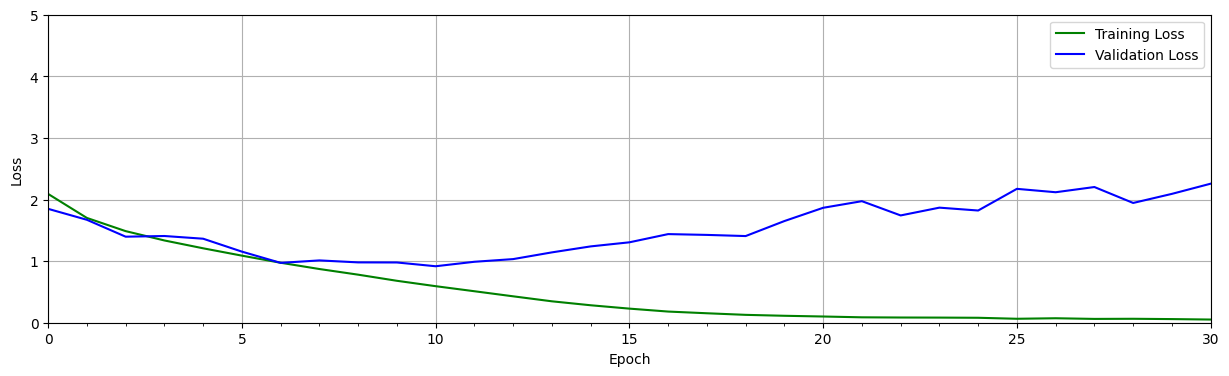

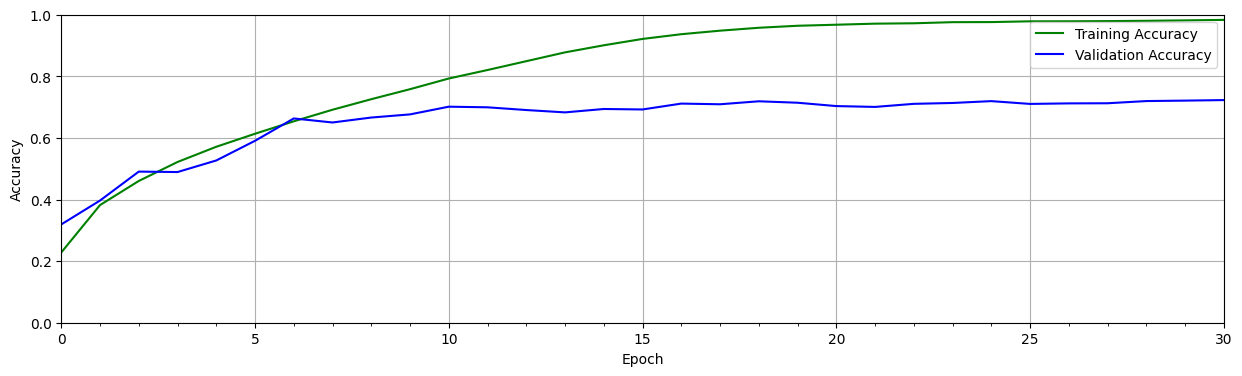

In [13]:
# Retrieve training results.
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]

plot_results(
    [train_loss, valid_loss],
    ylabel="Loss",
    ylim=[0.0, 5.0],
    metric_name=["Training Loss", "Validation Loss"],
    color=["g", "b"],
)

plot_results(
    [train_acc, valid_acc],
    ylabel="Accuracy",
    ylim=[0.0, 1.0],
    metric_name=["Training Accuracy", "Validation Accuracy"],
    color=["g", "b"],
)

The results from our baseline model reveal that the model is **overfitting**. Notice that the validation loss increases after about ten epochs of training while the training loss continues to decline. This means that the network learns how to model the training data well but does not generalize to unseen test data well.

## Dropout Model
To help mitigate the overfitting problem of the above model, we need to employ **reguralization** strategies. One approach is **Dropout** which is implemented in Keras **after** the max pooling layers as a special layer type that randomly drops a percentage of neurons during the training process.


<img src='https://learnopencv.com/wp-content/uploads/2023/01/tensorflow-keras-cnn-dropout-example.png' width=650 align='center'>

In the diagram below, we add a `dropout` layer at the end of each convolutional block and also after the dense layer in the classifier. The input argument to the Dropout function is the fraction of neurons to (randomly) drop from the previous layer during the training process.

<img src='https://learnopencv.com/wp-content/uploads/2023/01/tensorflow-keras-cnn-dropout-architecture.png' width=900 align='center'>

In [14]:
# Define the model now with Dropout
def cnn_model_dropout(input_shape=(32, 32, 3)):

    model = Sequential()

    #------------------------------------
    # Conv Block 1: 32 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    #------------------------------------
    # Conv Block 2: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    #------------------------------------
    # Conv Block 3: 64 Filters, MaxPool.
    #------------------------------------
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    #------------------------------------
    # Flatten the convolutional features.
    #------------------------------------
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    return model

In [15]:
# Create the dropout model
model_dropout = cnn_model_dropout()
model_dropout.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        36928     
                                                      

In [16]:
# Compile the dropout model
model_dropout.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [17]:
# Train the dropout model
history = model_dropout.fit(X_train,
                            y_train,
                            batch_size=TrainingConfig.BATCH_SIZE,
                            epochs=TrainingConfig.EPOCHS,
                            verbose=1,
                            validation_split=.3,
                           )

Epoch 1/31
137/137 [==============================] - 7s 34ms/step - loss: 2.1488 - accuracy: 0.2077 - val_loss: 1.9363 - val_accuracy: 0.3187
Epoch 2/31
137/137 [==============================] - 4s 28ms/step - loss: 1.8417 - accuracy: 0.3328 - val_loss: 1.6621 - val_accuracy: 0.3902
Epoch 3/31
137/137 [==============================] - 4s 26ms/step - loss: 1.6481 - accuracy: 0.4056 - val_loss: 1.5514 - val_accuracy: 0.4365
Epoch 4/31
137/137 [==============================] - 4s 28ms/step - loss: 1.5022 - accuracy: 0.4564 - val_loss: 1.3738 - val_accuracy: 0.4969
Epoch 5/31
137/137 [==============================] - 4s 26ms/step - loss: 1.3839 - accuracy: 0.5005 - val_loss: 1.4102 - val_accuracy: 0.4900
Epoch 6/31
137/137 [==============================] - 4s 26ms/step - loss: 1.2806 - accuracy: 0.5415 - val_loss: 1.1670 - val_accuracy: 0.5783
Epoch 7/31
137/137 [==============================] - 4s 26ms/step - loss: 1.1882 - accuracy: 0.5794 - val_loss: 1.0493 - val_accuracy: 0.6275

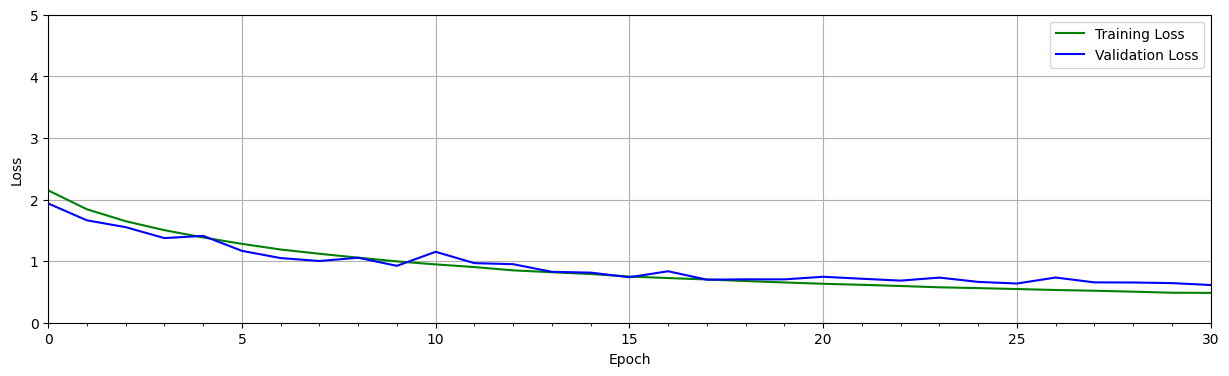

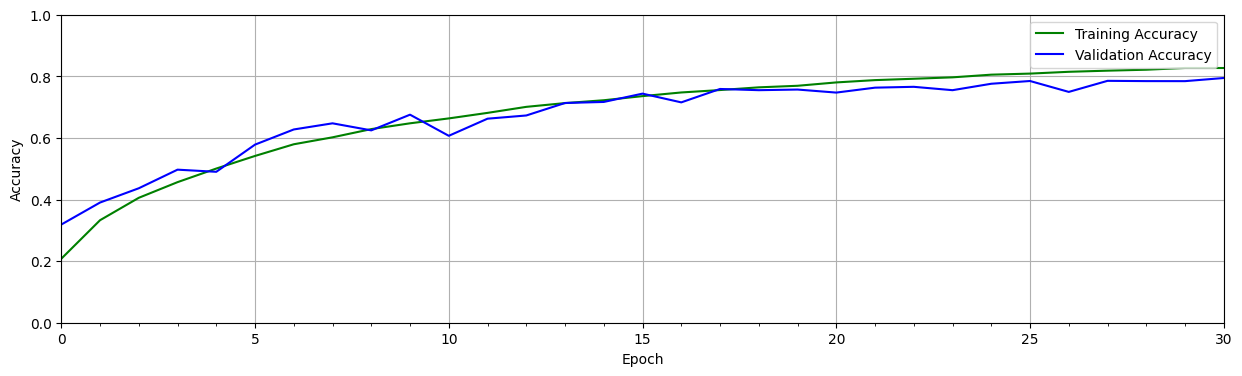

In [19]:
# Evaluate Dropout model performance.
train_loss = history.history["loss"]
train_acc  = history.history["accuracy"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_accuracy"]

plot_results(
    [train_loss, valid_loss],
    ylabel="Loss",
    ylim=[0.0, 5.0],
    metric_name=["Training Loss", "Validation Loss"],
    color=["g", "b"],
)

plot_results(
    [train_acc, valid_acc],
    ylabel="Accuracy",
    ylim=[0.0, 1.0],
    metric_name=["Training Accuracy", "Validation Accuracy"],
    color=["g", "b"],
)

In the plots above, the training curves align very closely with the validation curves. Also, notice that we achieve a higher validation accuracy than the baseline model that did not contain dropout

## Save model


We can easily save a model using the `save()` method which will save the model to the file system in the 'SavedModel' format. This method creates a folder on the file system. Within this folder, the model architecture and training configuration (including the optimizer, losses, and metrics) are stored in `saved_model.pb`. The `variables/` folder contains a standard training checkpoint file that includes the weights of the model. We will delve into these details in later modules. For now, let's save the trained model, and then we'll load it in the next code cell with a different name and continue using it in the remainder of the notebook.

In [20]:
model_dropout.save("model_dropout")

In [21]:
from tensorflow.keras import models
reloaded_model_dropout = models.load_model('model_dropout')

In [22]:
# Evaluate the saved model
test_loss, test_acc = reloaded_model_dropout.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc*100:.3f}")

313/313 [==============================] - 2s 4ms/step - loss: 0.6218 - accuracy: 0.7900
Test accuracy: 79.000


## Prediction On Sample Test Images

In [23]:
def evaluate_model(dataset, model):
    class_names = [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ]
    num_rows = 3
    num_cols = 6

    # Retrieve a number of images from the dataset.
    data_batch = dataset[0 : num_rows * num_cols]

    # Get predictions from model.
    predictions = model.predict(data_batch)

    plt.figure(figsize=(20, 8))
    num_matches = 0

    for idx in range(num_rows * num_cols):
        ax = plt.subplot(num_rows, num_cols, idx + 1)
        plt.axis("off")
        plt.imshow(data_batch[idx])

        pred_idx = tf.argmax(predictions[idx]).numpy()
        truth_idx = np.nonzero(y_test[idx])

        title = str(class_names[truth_idx[0][0]]) + " : " + str(class_names[pred_idx])
        title_obj = plt.title(title, fontdict={"fontsize": 13})

        if pred_idx == truth_idx:
            num_matches += 1
            plt.setp(title_obj, color="g")
        else:
            plt.setp(title_obj, color="r")

        acc = num_matches / (idx + 1)
    print("Prediction accuracy: ", int(100 * acc) / 100)

    return

1/1 [==============================] - 0s 480ms/step
Prediction accuracy:  0.83


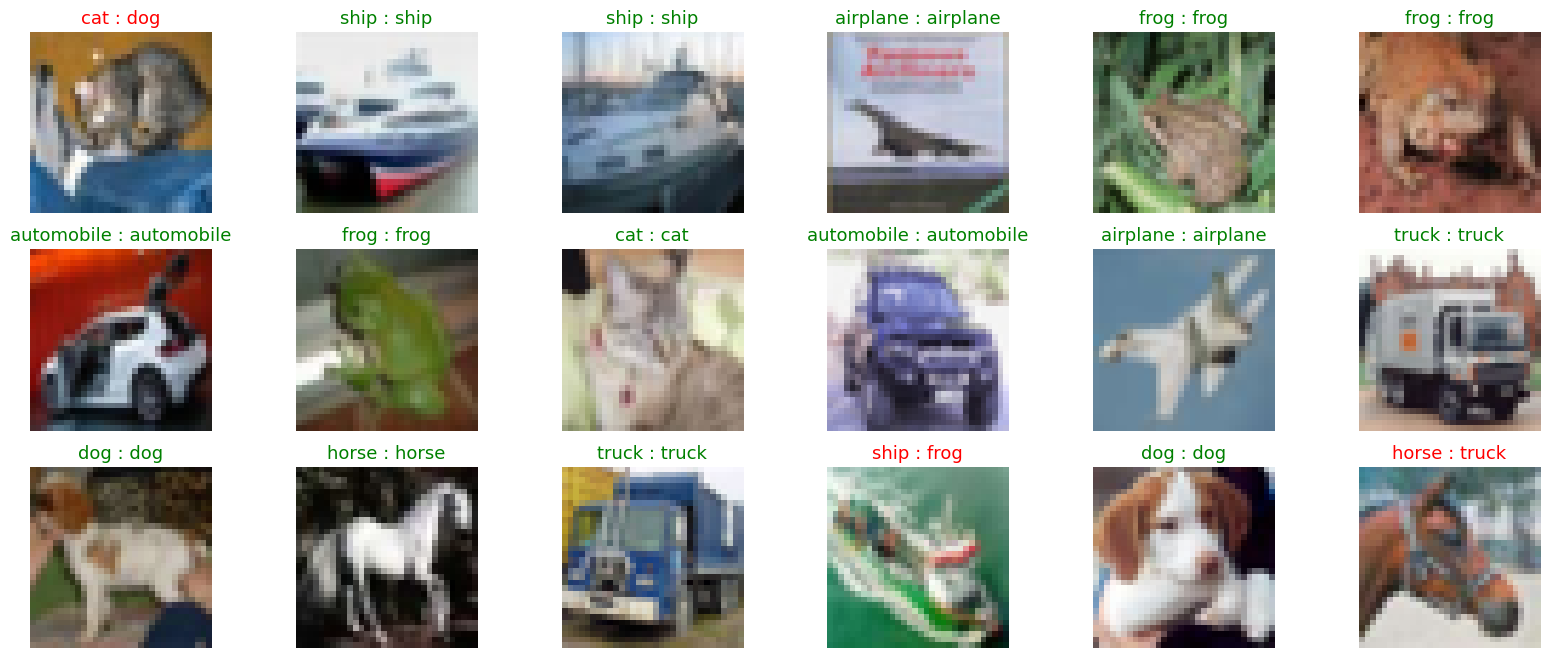

In [24]:
evaluate_model(X_test, reloaded_model_dropout)

##Confusion Matrix


In [25]:
# Generate predictions for the test dataset.
predictions = reloaded_model_dropout.predict(X_test)

# For each sample image in the test dataset, select the class label with the highest probability.
predicted_labels = [np.argmax(i) for i in predictions]

313/313 [==============================] - 1s 2ms/step


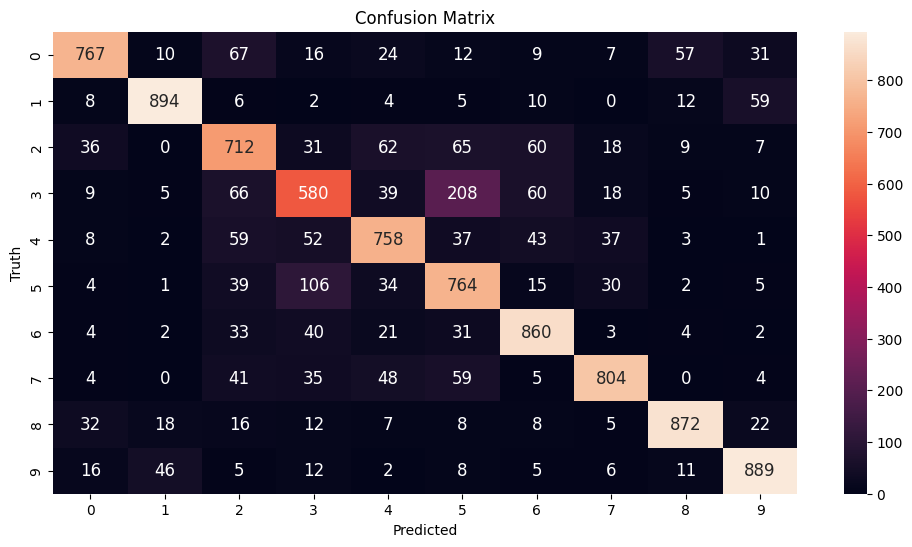

In [26]:
# Convert one-hot encoded labels to integers.
y_test_integer_labels = tf.argmax(y_test, axis=1)

# Generate a confusion matrix for the test dataset.
cm = tf.math.confusion_matrix(labels=y_test_integer_labels, predictions=predicted_labels)

# Plot the confusion matrix as a heatmap.
plt.figure(figsize=[12, 6])
import seaborn as sn

sn.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 12})
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()

## Conclusion
In this notebook, we implemented TensorFlow and Keras to define and train a simple convolutional neural network. Since the model overfit the training data, and we used `dropout` layers to reduce the overfitting and improve the model's performance on the validation dataset. We also saved the model to file system for efficient future use.